# Correct LADUMA phot-z's using Hannah's method

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic

def bin_bootstrap(vals):
    nbs = 5000
    data = np.random.choice(vals, size=(len(vals),5000))
    return np.std(np.median(data,axis=0))

mad = lambda xx: np.median(np.abs(xx-np.median(xx)))
def bin_bootstrap_mad(vals):
    nbs = 5000
    data = np.random.choice(vals, size=(len(vals),5000))
    return np.std([mad(row) for row in data])

# Prepare data

In [2]:
data = pd.read_hdf('./zou/xmmservs_laduma_merged_noabsmag.hdf5')

In [3]:
len(data)

813133

In [4]:
data = data[~data.zphot.isna() & ~data.mag_R_VOICE.isna()]

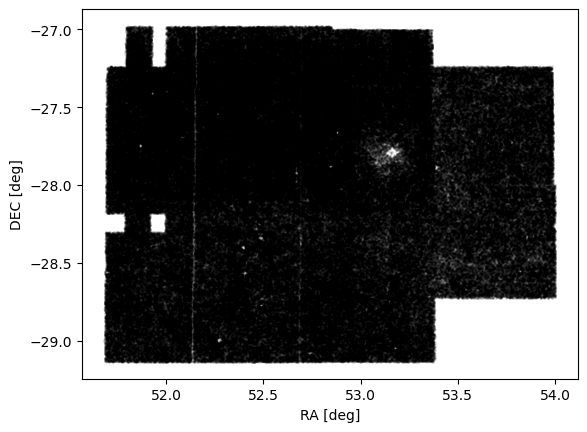

In [5]:
plt.figure()
plt.scatter(data.RA, data.DEC, color='k', alpha=0.1, s=1, rasterized=True)
plt.xlabel("RA [deg]")
plt.ylabel("DEC [deg]")
plt.show()

In [6]:
# need to get combined zspec column
combinedzspec = data.ZBESTNEW_zspecfile.to_numpy()
zspecxmm = data.zspec.to_numpy()
sel = np.where(np.isnan(combinedzspec))
combinedzspec[sel] = zspecxmm[sel]
data.loc[:,'combinedzspec'] = combinedzspec
np.sum(np.isnan(combinedzspec))

609331

In [7]:
magbins = np.arange(15,30,0.5)
zspecdata = data[~data.combinedzspec.isna() & (data.combinedzspec!=0.0)]
zphotdata = data[~data.zphot.isna()]
zspechist, bedges = np.histogram(zspecdata.mag_R_VOICE, bins=magbins)
zphothist, _ = np.histogram(zphotdata.mag_R_VOICE, bins=magbins)

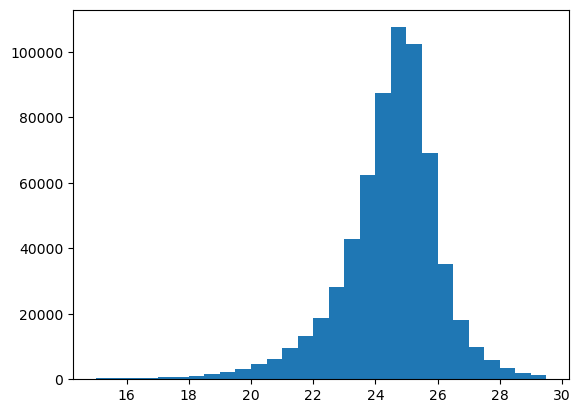

In [8]:
plt.hist(data.mag_R_VOICE, bins=magbins)
plt.show()

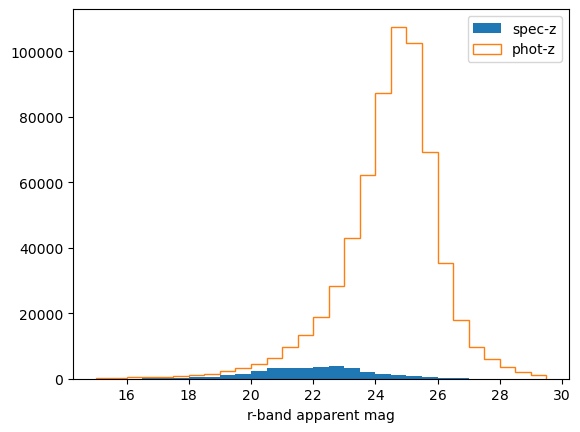

In [9]:
plt.figure()
plt.hist(zspecdata.mag_R_VOICE,bins=magbins, label='spec-z')
plt.hist(zphotdata.mag_R_VOICE,bins=magbins,histtype='step', label='phot-z')
plt.xlabel("r-band apparent mag")
plt.legend(loc='best')
plt.show()

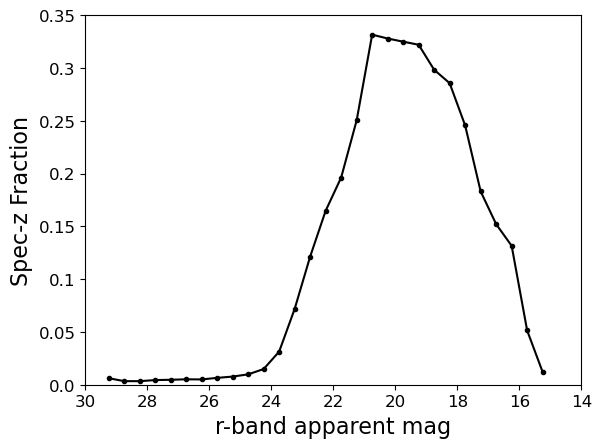

Overall spec-z fraction: 0.05


In [17]:
plt.figure()
binc = 0.5*(bedges[1:]+bedges[:-1])
plt.plot(binc,zspechist/(zphothist+zspechist),'k.-')
plt.ylabel("Spec-z Fraction",fontsize=16)
plt.xlabel("r-band apparent mag",fontsize=16)
tks = np.arange(14,32,2)
plt.gca().set_xticks(tks,labels=tks,fontsize=12)
tks = np.arange(0,0.4,0.05).round(2)
plt.gca().set_yticks(tks,labels=tks,fontsize=12)
plt.ylim(0,0.35)
plt.xlim(14,30)
plt.gca().invert_xaxis()
plt.show()

print("Overall spec-z fraction: {:0.2f}".format(np.sum(zspechist)/np.sum(zphothist+zspechist)))

# Correcting laduma photo-z's

In [ ]:
data_for_correction = data[(~data.zphot.isna()) & (~data.combinedzspec.isna()) & (data.combinedzspec!=0)]
data_for_correction.loc[:,'zphoterr'] = np.sqrt((data_for_correction.pz_ulim-data_for_correction.zphot)**2 + (data_for_correction.zphot-data_for_correction.pz_llim)**2)

from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(70.,0.3,0.7)
data_for_correction.loc[:,'absrmag_est'] =  (data_for_correction.mag_R_VOICE.to_numpy() + 5 - 5*np.log10(cosmo.luminosity_distance(data_for_correction.combinedzspec.to_numpy()).value * 1e6))

In [ ]:
len(data_for_correction)

## Pre-corrections

In [13]:
mad = lambda xx: np.median(np.abs(xx-np.median(xx)))

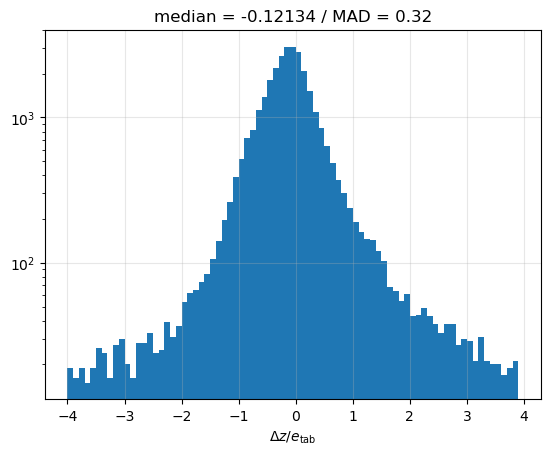

In [14]:
plt.figure()
bins = np.arange(-4,4,0.1)
values = (data_for_correction.zphot - data_for_correction.combinedzspec)/data_for_correction.zphoterr
plt.hist(values,bins=bins)
plt.yscale('log')
plt.xlabel(r'$\Delta z / e_{\rm tab}$')
plt.title('median = {:0.5f} / MAD = {:0.2f}'.format(np.median(values), mad(values)))
plt.grid(alpha=0.3)
plt.show()

## Correcting $\Delta z$

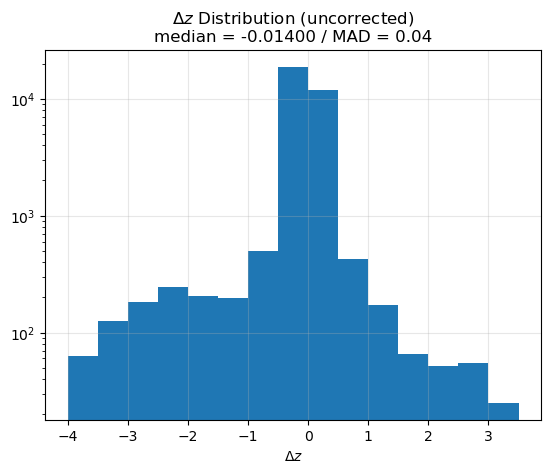

In [15]:
plt.figure()
bins = np.arange(-4,4,0.5)
values = (data_for_correction.zphot - data_for_correction.combinedzspec)
plt.hist(values,bins=bins)
plt.yscale('log')
plt.xlabel(r'$\Delta z$')
plt.title(r'$\Delta z$ Distribution (uncorrected)'+'\nmedian = {:0.5f} / MAD = {:0.2f}'.format(np.median(values), mad(values)))
plt.grid(alpha=0.3)
plt.show()

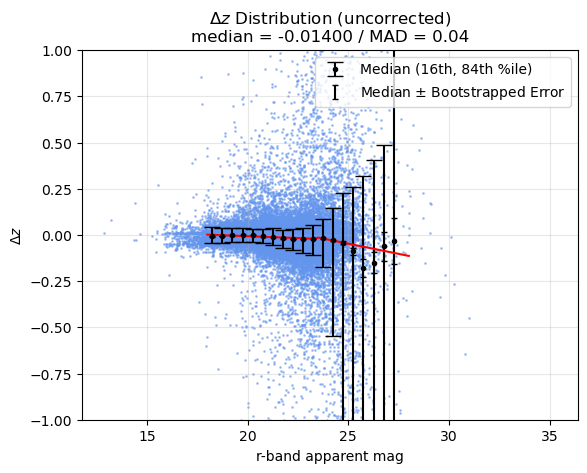

In [16]:
plt.figure()
bins = np.arange(18,28,0.5)
values = (data_for_correction.zphot - data_for_correction.combinedzspec)
plt.scatter(data_for_correction.mag_R_VOICE, values, color='cornflowerblue',alpha=0.5,s=1)
median,bedges,_ = binned_statistic(data_for_correction.mag_R_VOICE, values, statistic='median', bins=bins)
pt16,_,_ = binned_statistic(data_for_correction.mag_R_VOICE, values, statistic=lambda x:np.median(x)-np.percentile(x,16), bins=bins)
pt84,_,_ = binned_statistic(data_for_correction.mag_R_VOICE, values, statistic=lambda x:np.percentile(x,84)-np.median(x), bins=bins)
mederr,_,_= binned_statistic(data_for_correction.mag_R_VOICE, values, statistic=bin_bootstrap, bins=bins)
binc = 0.5*(bedges[1:]+bedges[:-1])
plt.errorbar(binc,median,yerr=[pt16,pt84],color='k', capsize=6,label='Median (16th, 84th %ile)',linestyle='None',marker='.')
plt.errorbar(binc,median,yerr=mederr,color='k', capsize=2,label=r'Median $\pm$ Bootstrapped Error',linestyle='None',marker='None')

# popt = np.polyfit(binc,median,w=1/np.sqrt(pt16*pt16+pt84*pt84), deg=1)
tx = np.linspace(18,28)
# plt.plot(tx,np.polyval(popt,tx),color='red')
def piecewise_linear(x,a1,b1,a2,b2):
    sel = (x>23.5)
    out = np.zeros_like(x)
    out[sel] = a2*x[sel]+b2
    out[~sel] = a1*x[~sel]+b1
    return out
    # if x>23.5:
    #     return a2*x+b2
    # else:
    #     return a1*x+b1
popt,pcov = curve_fit(piecewise_linear,binc,median,sigma=np.sqrt(pt16*pt16+pt84*pt84))
plt.plot(tx,piecewise_linear(tx,*popt),color='red')

#plt.yscale('log')
plt.ylabel(r'$\Delta z$')
plt.xlabel('r-band apparent mag')
plt.title(r'$\Delta z$ Distribution (uncorrected)'+'\nmedian = {:0.5f} / MAD = {:0.2f}'.format(np.median(values), mad(values)))
plt.grid(alpha=0.3)
plt.ylim(-1,1)
plt.legend(loc='upper right')
plt.show()

In [17]:
#data_for_correction.loc[:,'zphotcorr'] = data_for_correction.loc[:,'zphot'] - np.polyval(popt,data_for_correction.mag_R_VOICE)
data_for_correction.loc[:,'zphotcorr'] = data_for_correction.loc[:,'zphot'] - piecewise_linear(data_for_correction.mag_R_VOICE,*popt)

/tmp/ipykernel_1079796/3535206990.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_correction.loc[:,'zphotcorr'] = data_for_correction.loc[:,'zphot'] - piecewise_linear(data_for_correction.mag_R_VOICE,*popt)


KeyboardInterrupt: 

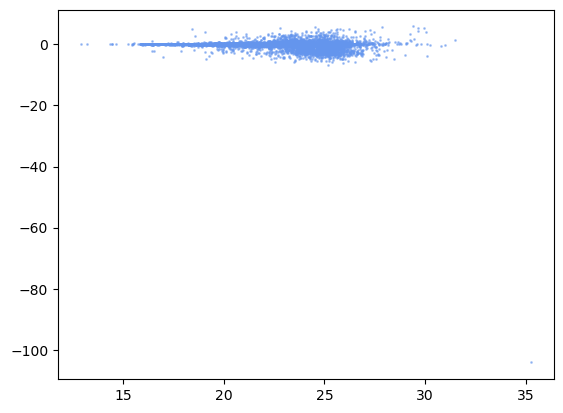

In [18]:
plt.figure()
bins = np.arange(18,28,0.5)
values = (data_for_correction.zphotcorr - data_for_correction.combinedzspec)
plt.scatter(data_for_correction.mag_R_VOICE, values, color='cornflowerblue',alpha=0.5,s=1)
median,bedges,_ = binned_statistic(data_for_correction.mag_R_VOICE, values, statistic='median', bins=bins)
pt16,_,_ = binned_statistic(data_for_correction.mag_R_VOICE, values, statistic=lambda x:np.median(x)-np.percentile(x,16), bins=bins)
pt84,_,_ = binned_statistic(data_for_correction.mag_R_VOICE, values, statistic=lambda x:np.percentile(x,84)-np.median(x), bins=bins)
mederr,_,_= binned_statistic(data_for_correction.mag_R_VOICE, values, statistic=bin_bootstrap, bins=bins)
binc = 0.5*(bedges[1:]+bedges[:-1])
plt.errorbar(binc,median,yerr=[pt16,pt84],color='k', capsize=6,label='Median (16th, 84th %ile)',linestyle='None',marker='.')
plt.errorbar(binc,median,yerr=mederr,color='k', capsize=2,label=r'Median $\pm$ Bootstrapped Error',linestyle='None',marker='None')

# popt = np.polyfit(binc,median,w=1/np.sqrt(pt16*pt16+pt84*pt84), deg=1)
# tx = np.linspace(18,28)
# plt.plot(tx,np.polyval(popt,tx),color='red')

#plt.yscale('log')
plt.ylabel(r'$\Delta z_{\rm corr}$')
plt.xlabel('r-band apparent mag')
plt.title(r'$\Delta z_{\rm corr}$ Distribution'+'\nmedian = {:0.5f} / MAD = {:0.2f}'.format(np.median(values), mad(values)))
plt.grid(alpha=0.3)
plt.ylim(-1,1)
plt.legend(loc='upper right')
plt.show()

# Correcting Errors

In [ ]:
plt.figure()
bins = np.arange(18,28,0.5)
values = (data_for_correction.zphotcorr - data_for_correction.combinedzspec) / data_for_correction.zphoterr
madvalues,bedges,_ = binned_statistic(data_for_correction.mag_R_VOICE, values, statistic=mad, bins=bins)
madvalueserr,_,_= binned_statistic(data_for_correction.mag_R_VOICE, values, statistic=bin_bootstrap_mad, bins=bins)
binc = 0.5*(bedges[1:]+bedges[:-1])
plt.errorbar(binc,madvalues,yerr=madvalueserr,color='k', capsize=2,label=r'MAD $\pm$ Bootstrapped Error',linestyle='None',marker='.')

popt,pcov = curve_fit(lambda x,a,b,c:(a*x*x)+b*x+c, binc[0:-7], madvalues[0:-7], sigma=madvalueserr[0:-7], absolute_sigma=True)
tx = np.linspace(18,28)
plt.plot(tx,np.polyval(popt,tx),color='red')
# popt,pcov = curve_fit(piecewise_linear,binc,madvalues,sigma=madvalueserr,absolute_sigma=True)#,p0=[0.,0.03,0.3,-7])
# plt.plot(tx,piecewise_linear(tx,*popt),color='red')

#plt.yscale('log')
plt.ylabel(r'MAD($\Delta z_{\rm corr}/e_{\rm tab}$)')
plt.xlabel('r-band apparent mag')
plt.title(r'$\Delta z_{\rm corr}/e_{\rm tab}$ Distribution (uncorrected errors)'+'\nMAD dz_corr/e_tab = {:0.3E}'.format(mad(values)))
plt.grid(alpha=0.3)
#plt.ylim(-1,1)
plt.legend(loc='upper left')
plt.show()

In [ ]:
data_for_correction.loc[:,'zphoterrcorr'] = data_for_correction['zphoterr'] * np.polyval(popt,data_for_correction['mag_R_VOICE'])

In [ ]:
plt.figure()
bins = np.arange(18,28,0.5)
values = (data_for_correction.zphotcorr - data_for_correction.combinedzspec) / data_for_correction.zphoterrcorr
madvalues,bedges,_ = binned_statistic(data_for_correction.mag_R_VOICE, values, statistic=mad, bins=bins)
madvalueserr,_,_= binned_statistic(data_for_correction.mag_R_VOICE, values, statistic=bin_bootstrap_mad, bins=bins)
binc = 0.5*(bedges[1:]+bedges[:-1])
plt.errorbar(binc,madvalues,yerr=madvalueserr,color='k', capsize=2,label=r'MAD $\pm$ Bootstrapped Error',linestyle='None',marker='.')

# popt = np.polyfit(binc[0:5],madvalues[0:5],w=1/madvalueserr[0:5], deg=1)
# tx = np.linspace(18,28)
# plt.plot(tx,np.polyval(popt,tx),color='red')
# popt,pcov = curve_fit(piecewise_linear,binc,madvalues,sigma=madvalueserr,absolute_sigma=True)#,p0=[0.,0.03,0.3,-7])
# plt.plot(tx,piecewise_linear(tx,*popt),color='red')

#plt.yscale('log')
plt.ylabel(r'MAD($\Delta z_{\rm corr}/e_{\rm tab,\,corr}$)')
plt.xlabel('r-band apparent mag')
plt.title(r'$\Delta z_{\rm corr}/e_{\rm tab,corr}$ Distribution (uncorrected errors)'+'\nMAD dz_corr/e_tab_corr = {:0.3E}'.format(mad(values)))
plt.grid(alpha=0.3)
#plt.ylim(-1,1)
plt.legend(loc='upper left')
plt.show()

In [ ]:
[kk for kk in data_for_correction.keys()]